# Read in data and compute nearest actives and rd_filters

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

def get_sim_df(actives_df, prosp_df, dataset):
    X_train_actives = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in actives_df['1024 MorganFP Radius 2']]).astype(float)
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prosp_df['1024 MorganFP Radius 2']]).astype(float)
    train_prosp_tandist = pairwise_distances(X_prosp, X_train_actives, metric='jaccard')
    sim_info = []
    for i in range(train_prosp_tandist.shape[0]):
        prosp_id = prosp_df['Index ID'].iloc[i]; 
        closest_active_idx = np.argmin(train_prosp_tandist[i,:]); 
        dist = train_prosp_tandist[i,closest_active_idx]
        ctrid = actives_df['Index ID'].iloc[closest_active_idx];
        
        
        sim_info.append((prosp_id, ctrid, dist))
        
    sim_df = pd.DataFrame(data=sim_info, 
                          columns=['Index ID', 'Closest {} Active ID'.format(dataset), 'Closest {} Active TanDist'.format(dataset)])
    return sim_df

top_real_clustering = pd.read_csv('../datasets/real_costs_clustered_v3.csv.gz')
train_df = pd.read_csv('../datasets/folds/training_df_single_fold_with_clustering.csv.gz')
ams_df = pd.read_csv('../datasets/ams_order_results.csv.gz')

train_actives = train_df[train_df['PriA-SSB AS Activity'] == 1]
sim_train_df = get_sim_df(train_actives, top_real_clustering, 'Train')

ams_actives = ams_df[ams_df['Hit'] == 1]
sim_ams_df = get_sim_df(ams_actives, top_real_clustering, 'AMS')

top_real_clustering = top_real_clustering.merge(sim_train_df, on='Index ID')
top_real_clustering = top_real_clustering.merge(sim_ams_df, on='Index ID')

In [3]:
import sys
sys.path.insert(0, './rd_filters/')
from rd_filters import *

alert_file_name = './rd_filters/data/alert_collection.csv'
rules_file_name = './rd_filters/data/rules.json'
rf = RDFilters(alert_file_name)
rules_file_path = get_config_file(rules_file_name, "FILTER_RULES_DATA")
rule_dict = read_rules(rules_file_path)
rule_list = [x.replace("Rule_", "") for x in rule_dict.keys() if x.startswith("Rule") and rule_dict[x]]
rule_str = " and ".join(rule_list)
print(f"Using alerts from {rule_str}")
rf.build_rule_list(rule_list)

input_data = top_real_clustering[["rdkit SMILES", "idnumber"]].values.tolist()

start_time = time.time()
p = Pool(1)
filter_res = list(p.map(rf.evaluate, input_data))
rd_df = pd.DataFrame(filter_res, columns=["SMILES", "idnumber", "RD_FILTER", "MW", "LogP", "HBD", "HBA", "TPSA"])
filter_binary = np.zeros((rd_df.shape[0],), dtype='uint8')
for index, row in rd_df.iterrows():
    if row['RD_FILTER'] == "OK":
        filter_binary[index] = 1
rd_df["RD_FILTER"] = filter_binary
rd_df = rd_df[["idnumber", "RD_FILTER", "LogP"]]

top_real_clustering = top_real_clustering.merge(rd_df, on='idnumber')
# aggregate costs for 1-50
top_real_clustering['Price'] = top_real_clustering[['Price for 11-50 cmpds', 'Price for 40-49 cmpds']].sum(axis=1).values

Using alerts from Inpharmatica


In [4]:
des_cols = ['ID Enamine', 
            'REAL SMILES', 'rdkit SMILES', 'PAINS Filter', 
               'TB_0.4 ID', 'Hit', 'Is Train cluster?',
               'Is Train active cluster?', 'Is AMS cluster?',
               'Is AMS active cluster?', 'rf_preds',
               'Price', 'Status', 'Delivery term, weeks',
               'Closest Train Active ID', 'Closest Train Active TanDist',
               'Closest AMS Active ID', 'Closest AMS Active TanDist', '1024 MorganFP Radius 2',
               "RD_FILTER", "MW", "LogP", "HBD", "HBA", "TPSA"]
df = top_real_clustering[des_cols].sort_values('rf_preds', ascending=False)
df['rf_rank'] = df['rf_preds'].rank(method='first', ascending=False)

---
# Apply filters

In [24]:
print('Shape: {}'.format(df.shape[0]))
# get cpds in clusters that don't exist in train or ams ACTIVE clusters
prune_df1 = df[(df['Is Train active cluster?'] == 0) & (df['Is AMS active cluster?'] == 0)]
failed_df1 = df[~df['ID Enamine'].isin(prune_df1['ID Enamine'])]
print('1. Shape: {}'.format(prune_df1.shape[0]))

# pass PAINS and RD_FILTERS filter
prune_df2 = prune_df1[(prune_df1['PAINS Filter'] == 1) * (prune_df1['RD_FILTER'] == 1)]
failed_df2 = prune_df1[~prune_df1['ID Enamine'].isin(prune_df2['ID Enamine'])]
print('2. Shape: {}'.format(prune_df2.shape[0]))

# take only cpds that are from from tain and ams actives
tandist_thresh=0.35
prune_df3 = prune_df2[(prune_df2['Closest Train Active TanDist'] >= tandist_thresh) & (prune_df2['Closest AMS Active TanDist'] >= tandist_thresh)]
failed_df3 = prune_df2[~prune_df2['ID Enamine'].isin(prune_df3['ID Enamine'])]
print('3. Shape: {}'.format(prune_df3.shape[0]))

# get highest prediction from each cluster
prune_df4 = prune_df3.drop_duplicates(subset='TB_0.4 ID', keep='first').reset_index(drop=True)
failed_df4 = prune_df3[~prune_df3['ID Enamine'].isin(prune_df4['ID Enamine'])]
print('4. Shape: {}'.format(prune_df4.shape[0]))

Shape: 5620
1. Shape: 2679
2. Shape: 1604
3. Shape: 1354
4. Shape: 311


---
# Select 100 diverse from the remaining

In [5]:
num_cpds = 100
cpds_to_select = [0] # first select cpd with highest rf_rank

X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prune_df4['1024 MorganFP Radius 2']]).astype(float)
for i in range(1, 100):
    x = X_prosp[cpds_to_select,:]
    remaining_cpds = np.setdiff1d(np.arange(X_prosp.shape[0]), cpds_to_select)
    y = X_prosp[remaining_cpds,:]
    tandist = pairwise_distances(y, x, metric='jaccard')
    farthest_idx = np.argmax(tandist.mean(axis=1)); 
    
    cpds_to_select.append(remaining_cpds[farthest_idx])
    
final_list = prune_df4.iloc[cpds_to_select,:]
final_list = final_list.sort_values('rf_preds', ascending=False)

In [6]:
final_list.to_csv('../datasets/enamine_final_list_v2.csv.gz', index=False)

In [7]:
final_list[['MW','LogP','HBD','HBA','TPSA']].describe().loc[['min', 'max']]

,ID Enamine,REAL SMILES,rdkit SMILES,PAINS Filter,TB_0.4 ID,Hit,Is Train cluster?,Is Train active cluster?,Is AMS cluster?,Is AMS active cluster?,...,Closest AMS Active ID,Closest AMS Active TanDist,1024 MorganFP Radius 2,RD_FILTER,MW,LogP,HBD,HBA,TPSA,rf_rank
0,Z3295052620,CC1CC(NC2=NC(C3=CC=CC=N3)=CS2)C1,CC1CC(Nc2nc(-c3ccccn3)cs2)C1,1,262,NaN,0,0,0,0,...,427760,0.390244,0000000000000000000000000000000001000000000000...,1,245.351,3.41550,1,4,37.81,104.0
14,Z1437547057,NC1=CN=NC(NN=CC2=CC=CC=N2)=C1Cl,Nc1cnnc(NN=Cc2ccccn2)c1Cl,1,49033,NaN,1,0,0,0,...,428173,0.722222,0000000000000000000010000000000000000000000000...,1,248.677,1.55320,2,6,89.08,338.0
51,Z1741972899,O=C(O)C1=CC(C2=CC=CC=C2)=CC=N1,O=C(O)c1cc(-c2ccccc2)ccn1,1,19314,NaN,0,0,0,0,...,427530,0.606061,0000000000000000000000000000000000000000000000...,1,199.209,2.44680,1,2,50.19,923.0
52,Z3404834383,O=C(NC1=NC(C2=CC=CC=N2)=CS1)C12CC=CC(C1)OC2,O=C(Nc1nc(-c2ccccn2)cs1)C12CC=CC(C1)OC2,1,56739,NaN,0,0,0,0,...,427648,0.484848,0000000000000000000000000000000010001000000000...,1,313.374,2.87880,1,5,64.11,952.0
53,Z3295148399,C1=CC=C(C2=CSC(NC3COC4(CCC4)C3)=N2)N=C1,c1ccc(-c2csc(NC3COC4(CCC4)C3)n2)nc1,1,19316,NaN,0,0,0,0,...,427926,0.508772,0000100000000000000000000000000000001000000000...,1,287.388,3.32860,1,5,47.04,988.0
58,Z734817070,ClC1=CC=CN=C1NN=CC1=CC=CC=N1,Clc1cccnc1NN=Cc1ccccn1,1,3118,NaN,1,0,1,0,...,427530,0.714286,0000000000000000000100000000000000000000000000...,1,232.674,2.57600,1,4,50.17,1023.0
61,Z1172208679,C1=CC=C(C2=NC3=C(CCC3)C(N3CCCC3)=N2)N=C1,c1ccc(-c2nc3c(c(N4CCCC4)n2)CCC3)nc1,1,1034,NaN,0,0,1,0,...,427757,0.409091,0000100000000000000000000000000000000000000000...,1,266.348,2.62750,0,4,41.91,1076.0
63,Z1245633363,C1=CC=C(C2=NC=C[NH]2)N=C1,c1ccc(-c2ncc[nH]2)nc1,1,487277,NaN,0,0,0,0,...,427524,0.500000,0000000000000000000000000000000000000000000000...,1,145.165,1.47170,1,2,41.57,1100.0
65,Z1313381195,CC1=N[NH]C(SCC(=O)NC2=NN=C(C3=CC=CC=N3)[NH]2)=N1,Cc1n[nH]c(SCC(=O)Nc2nnc(-c3ccccn3)[nH]2)n1,1,236,NaN,0,0,0,0,...,427393,0.515152,0000000000000000000000000000000001000000010000...,1,316.350,1.02402,3,7,125.13,1111.0
70,Z1763598930,ClC1=CN=CN=C1NN=CC1=CC=CC=N1,Clc1cncnc1NN=Cc1ccccn1,1,30624,NaN,0,0,0,0,...,427996,0.717391,0000000000000000000000000000000000000000000000...,1,233.662,1.97100,1,5,63.06,1211.0


In [14]:
top_real_clustering.columns

Index(['idnumber', 'REAL SMILES', 'rdkit SMILES', 'rf_preds', 'file',
       '1024 MorganFP Radius 2', 'PAINS Filter', 'reagent1', 'reagent2',
       'reagent3', 'reagent4', 'reaction', 'MW', 'sLogP', 'HBA', 'HBD',
       'RotBonds', 'FSP3', 'TPSA', 'QED', 'PAINS', 'BRENK', 'NIH', 'ZINC',
       'LILLY', 'lead-like', '350/3_lead-like', 'fragments',
       'strict_fragments', 'PPI_modulators', 'natural_product-like',
       'Index ID', 'TB_0.4 ID', 'TB_0.4 Leader', 'Hit', 'Is Train cluster?',
       'Is Train active cluster?', 'Is AMS cluster?', 'Is AMS active cluster?',
       'ID Enamine', 'Amount, mg', 'Price for 1-10 cmpds',
       'Price for 11-50 cmpds', 'Price for 20-29 cmpds',
       'Price for 30-39 cmpds', 'Price for 40-49 cmpds', 'Status',
       'Delivery term, weeks', 'Closest Train Active ID',
       'Closest Train Active TanDist', 'Closest AMS Active ID',
       'Closest AMS Active TanDist', 'RD_FILTER', 'LogP', 'Price'],
      dtype='object')

In [15]:
prune_df = df[(df['Is Train active cluster?'] == 0) & (df['Is AMS active cluster?'] == 0)]

5620

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('../datasets/enamine_final_list_v2.csv.gz')
prices = pd.read_csv('../datasets/real_final_100_v2.csv')
prices = prices[prices['Price, USD'] > 200].iloc[:-1,:]
ex_df = df[df['ID Enamine'].isin(prices['ID Enamine'])]

In [28]:
rf1 = df['rf_preds']
rf2 = ex_df['rf_preds']

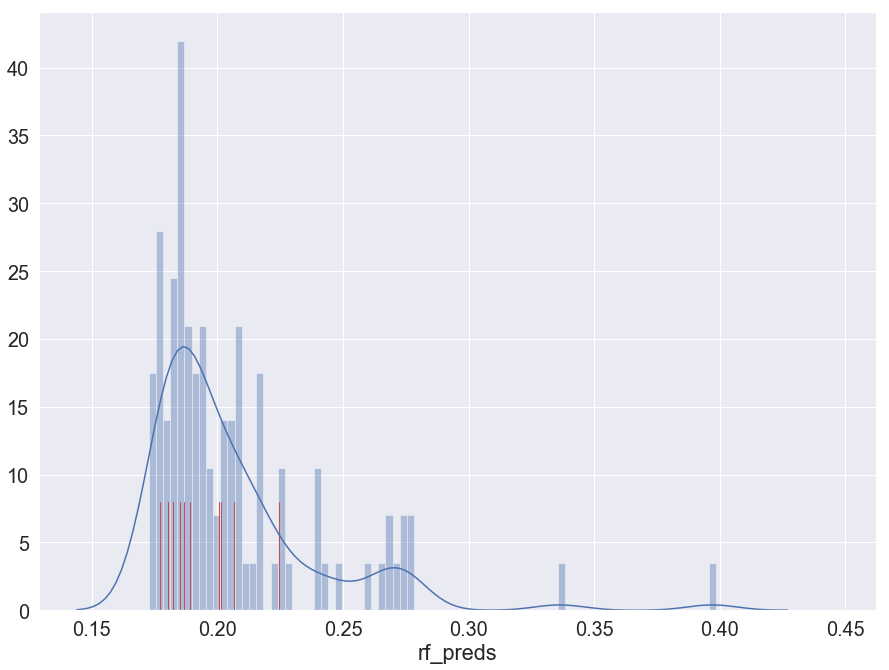

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);

plt.figure(figsize=(15,11))

for x in rf2.values:
    plt.plot([x, x], [0, 8], color='r', linewidth=1)
    
bin_range=np.linspace(rf1.min()-0.01, rf1.max()+0.05, 100)
sns.distplot(rf1, bins=bin_range, norm_hist=False, kde=True)  


plt.show()

In [37]:
rf1.max(), rf1.min()

(0.396999675872, 0.17399991888900002)

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('../datasets/enamine_final_list_v2.csv.gz')
x = pd.read_csv('../datasets/last_order.csv')

In [4]:
df

,ID Enamine,REAL SMILES,rdkit SMILES,PAINS Filter,TB_0.4 ID,Hit,Is Train cluster?,Is Train active cluster?,Is AMS cluster?,Is AMS active cluster?,...,Closest AMS Active ID,Closest AMS Active TanDist,1024 MorganFP Radius 2,RD_FILTER,MW,LogP,HBD,HBA,TPSA,rf_rank
0,Z3295052620,CC1CC(NC2=NC(C3=CC=CC=N3)=CS2)C1,CC1CC(Nc2nc(-c3ccccn3)cs2)C1,1,262,NaN,0,0,0,0,...,427760,0.390244,0000000000000000000000000000000001000000000000...,1,245.351,3.41550,1,4,37.81,104.0
1,Z1437547057,NC1=CN=NC(NN=CC2=CC=CC=N2)=C1Cl,Nc1cnnc(NN=Cc2ccccn2)c1Cl,1,49033,NaN,1,0,0,0,...,428173,0.722222,0000000000000000000010000000000000000000000000...,1,248.677,1.55320,2,6,89.08,338.0
2,Z1741972899,O=C(O)C1=CC(C2=CC=CC=C2)=CC=N1,O=C(O)c1cc(-c2ccccc2)ccn1,1,19314,NaN,0,0,0,0,...,427530,0.606061,0000000000000000000000000000000000000000000000...,1,199.209,2.44680,1,2,50.19,923.0
3,Z3404834383,O=C(NC1=NC(C2=CC=CC=N2)=CS1)C12CC=CC(C1)OC2,O=C(Nc1nc(-c2ccccn2)cs1)C12CC=CC(C1)OC2,1,56739,NaN,0,0,0,0,...,427648,0.484848,0000000000000000000000000000000010001000000000...,1,313.374,2.87880,1,5,64.11,952.0
4,Z3295148399,C1=CC=C(C2=CSC(NC3COC4(CCC4)C3)=N2)N=C1,c1ccc(-c2csc(NC3COC4(CCC4)C3)n2)nc1,1,19316,NaN,0,0,0,0,...,427926,0.508772,0000100000000000000000000000000000001000000000...,1,287.388,3.32860,1,5,47.04,988.0
5,Z734817070,ClC1=CC=CN=C1NN=CC1=CC=CC=N1,Clc1cccnc1NN=Cc1ccccn1,1,3118,NaN,1,0,1,0,...,427530,0.714286,0000000000000000000100000000000000000000000000...,1,232.674,2.57600,1,4,50.17,1023.0
6,Z1172208679,C1=CC=C(C2=NC3=C(CCC3)C(N3CCCC3)=N2)N=C1,c1ccc(-c2nc3c(c(N4CCCC4)n2)CCC3)nc1,1,1034,NaN,0,0,1,0,...,427757,0.409091,0000100000000000000000000000000000000000000000...,1,266.348,2.62750,0,4,41.91,1076.0
7,Z1245633363,C1=CC=C(C2=NC=C[NH]2)N=C1,c1ccc(-c2ncc[nH]2)nc1,1,487277,NaN,0,0,0,0,...,427524,0.500000,0000000000000000000000000000000000000000000000...,1,145.165,1.47170,1,2,41.57,1100.0
8,Z1313381195,CC1=N[NH]C(SCC(=O)NC2=NN=C(C3=CC=CC=N3)[NH]2)=N1,Cc1n[nH]c(SCC(=O)Nc2nnc(-c3ccccn3)[nH]2)n1,1,236,NaN,0,0,0,0,...,427393,0.515152,0000000000000000000000000000000001000000010000...,1,316.350,1.02402,3,7,125.13,1111.0
9,Z1763598930,ClC1=CN=CN=C1NN=CC1=CC=CC=N1,Clc1cncnc1NN=Cc1ccccn1,1,30624,NaN,0,0,0,0,...,427996,0.717391,0000000000000000000000000000000000000000000000...,1,233.662,1.97100,1,5,63.06,1211.0


In [11]:
x[x['ID Enamine'].isin(df['ID Enamine'])].shape

(90, 6)

In [16]:
a = pd.merge(df, x, on='ID Enamine')[['ID Enamine', 'SMILES', 'REAL SMILES', 'rdkit SMILES']]
a['SMILES_2'] = 

(90, 4)

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

FP_radius=2
FP_size=1024
saltRemover = SaltRemover(defnFilename='../datasets/raw/Salts.txt')
rdkit_mols = a['SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mols = rdkit_mols.apply((lambda x: saltRemover.StripMol(x)))
a['rdkit SMILES 2'] = rdkit_mols.apply((lambda x: Chem.MolToSmiles(x)))

In [20]:
for idx, row in a.iterrows():
    assert row['rdkit SMILES'] == row['rdkit SMILES 2']

In [21]:
a

,ID Enamine,SMILES,REAL SMILES,rdkit SMILES,rdkit SMILES 2
0,Z3295052620,CC1CC(C1)NC2=NC(=CS2)C=3C=CC=CN3,CC1CC(NC2=NC(C3=CC=CC=N3)=CS2)C1,CC1CC(Nc2nc(-c3ccccn3)cs2)C1,CC1CC(Nc2nc(-c3ccccn3)cs2)C1
1,Z1437547057,NC=1C=NN=C(NN=CC=2C=CC=CN2)C1Cl,NC1=CN=NC(NN=CC2=CC=CC=N2)=C1Cl,Nc1cnnc(NN=Cc2ccccn2)c1Cl,Nc1cnnc(NN=Cc2ccccn2)c1Cl
2,Z1741972899,OC(=O)C=1C=C(C=CN1)C=2C=CC=CC2,O=C(O)C1=CC(C2=CC=CC=C2)=CC=N1,O=C(O)c1cc(-c2ccccc2)ccn1,O=C(O)c1cc(-c2ccccc2)ccn1
3,Z3404834383,O=C(NC1=NC(=CS1)C=2C=CC=CN2)C3(COC4C3)CC=C4,O=C(NC1=NC(C2=CC=CC=N2)=CS1)C12CC=CC(C1)OC2,O=C(Nc1nc(-c2ccccn2)cs1)C12CC=CC(C1)OC2,O=C(Nc1nc(-c2ccccn2)cs1)C12CC=CC(C1)OC2
4,Z3295148399,C1CC2(C1)CC(CO2)NC3=NC(=CS3)C=4C=CC=CN4,C1=CC=C(C2=CSC(NC3COC4(CCC4)C3)=N2)N=C1,c1ccc(-c2csc(NC3COC4(CCC4)C3)n2)nc1,c1ccc(-c2csc(NC3COC4(CCC4)C3)n2)nc1
5,Z734817070,ClC=1C=CC=NC1NN=CC=2C=CC=CN2,ClC1=CC=CN=C1NN=CC1=CC=CC=N1,Clc1cccnc1NN=Cc1ccccn1,Clc1cccnc1NN=Cc1ccccn1
6,Z1172208679,C1CCN(C1)C=2N=C(N=C3CCCC32)C=4C=CC=CN4,C1=CC=C(C2=NC3=C(CCC3)C(N3CCCC3)=N2)N=C1,c1ccc(-c2nc3c(c(N4CCCC4)n2)CCC3)nc1,c1ccc(-c2nc3c(c(N4CCCC4)n2)CCC3)nc1
7,Z1245633363,C1=CNC(=N1)C=2C=CC=CN2,C1=CC=C(C2=NC=C[NH]2)N=C1,c1ccc(-c2ncc[nH]2)nc1,c1ccc(-c2ncc[nH]2)nc1
8,Z1313381195,CC1=NNC(SCC(=O)NC2=NN=C(N2)C=3C=CC=CN3)=N1,CC1=N[NH]C(SCC(=O)NC2=NN=C(C3=CC=CC=N3)[NH]2)=N1,Cc1n[nH]c(SCC(=O)Nc2nnc(-c3ccccn3)[nH]2)n1,Cc1n[nH]c(SCC(=O)Nc2nnc(-c3ccccn3)[nH]2)n1
9,Z1763598930,ClC=1C=NC=NC1NN=CC=2C=CC=CN2,ClC1=CN=CN=C1NN=CC1=CC=CC=N1,Clc1cncnc1NN=Cc1ccccn1,Clc1cncnc1NN=Cc1ccccn1


,ID Enamine,REAL SMILES,rdkit SMILES,PAINS Filter,TB_0.4 ID,Hit,Is Train cluster?,Is Train active cluster?,Is AMS cluster?,Is AMS active cluster?,...,LogP,HBD,HBA,TPSA,rf_rank,"Amount, mg","Price, USD","Lead time, weeks",SMILES,MW_y
0,Z3295052620,CC1CC(NC2=NC(C3=CC=CC=N3)=CS2)C1,CC1CC(Nc2nc(-c3ccccn3)cs2)C1,1,262,NaN,0,0,0,0,...,3.41550,1,4,37.81,104.0,1,135,3-4,CC1CC(C1)NC2=NC(=CS2)C=3C=CC=CN3,245.34330
1,Z1437547057,NC1=CN=NC(NN=CC2=CC=CC=N2)=C1Cl,Nc1cnnc(NN=Cc2ccccn2)c1Cl,1,49033,NaN,1,0,0,0,...,1.55320,2,6,89.08,338.0,1,90,3-4,NC=1C=NN=C(NN=CC=2C=CC=CN2)C1Cl,248.67166
2,Z1741972899,O=C(O)C1=CC(C2=CC=CC=C2)=CC=N1,O=C(O)c1cc(-c2ccccc2)ccn1,1,19314,NaN,0,0,0,0,...,2.44680,1,2,50.19,923.0,1,44,1-2,OC(=O)C=1C=C(C=CN1)C=2C=CC=CC2,199.20536
3,Z3404834383,O=C(NC1=NC(C2=CC=CC=N2)=CS1)C12CC=CC(C1)OC2,O=C(Nc1nc(-c2ccccn2)cs1)C12CC=CC(C1)OC2,1,56739,NaN,0,0,0,0,...,2.87880,1,5,64.11,952.0,1,90,3-4,O=C(NC1=NC(=CS1)C=2C=CC=CN2)C3(COC4C3)CC=C4,313.37420
4,Z3295148399,C1=CC=C(C2=CSC(NC3COC4(CCC4)C3)=N2)N=C1,c1ccc(-c2csc(NC3COC4(CCC4)C3)n2)nc1,1,19316,NaN,0,0,0,0,...,3.32860,1,5,47.04,988.0,1,135,3-4,C1CC2(C1)CC(CO2)NC3=NC(=CS3)C=4C=CC=CN4,287.37998
5,Z734817070,ClC1=CC=CN=C1NN=CC1=CC=CC=N1,Clc1cccnc1NN=Cc1ccccn1,1,3118,NaN,1,0,1,0,...,2.57600,1,4,50.17,1023.0,1,90,3-4,ClC=1C=CC=NC1NN=CC=2C=CC=CN2,232.66896
6,Z1172208679,C1=CC=C(C2=NC3=C(CCC3)C(N3CCCC3)=N2)N=C1,c1ccc(-c2nc3c(c(N4CCCC4)n2)CCC3)nc1,1,1034,NaN,0,0,1,0,...,2.62750,0,4,41.91,1076.0,1,90,3-4,C1CCN(C1)C=2N=C(N=C3CCCC32)C=4C=CC=CN4,266.34092
7,Z1245633363,C1=CC=C(C2=NC=C[NH]2)N=C1,c1ccc(-c2ncc[nH]2)nc1,1,487277,NaN,0,0,0,0,...,1.47170,1,2,41.57,1100.0,1,29,1-2,C1=CNC(=N1)C=2C=CC=CN2,145.16128
8,Z1313381195,CC1=N[NH]C(SCC(=O)NC2=NN=C(C3=CC=CC=N3)[NH]2)=N1,Cc1n[nH]c(SCC(=O)Nc2nnc(-c3ccccn3)[nH]2)n1,1,236,NaN,0,0,0,0,...,1.02402,3,7,125.13,1111.0,1,90,3-4,CC1=NNC(SCC(=O)NC2=NN=C(N2)C=3C=CC=CN3)=N1,316.34168
9,Z1763598930,ClC1=CN=CN=C1NN=CC1=CC=CC=N1,Clc1cncnc1NN=Cc1ccccn1,1,30624,NaN,0,0,0,0,...,1.97100,1,5,63.06,1211.0,1,90,3-4,ClC=1C=NC=NC1NN=CC=2C=CC=CN2,233.65702


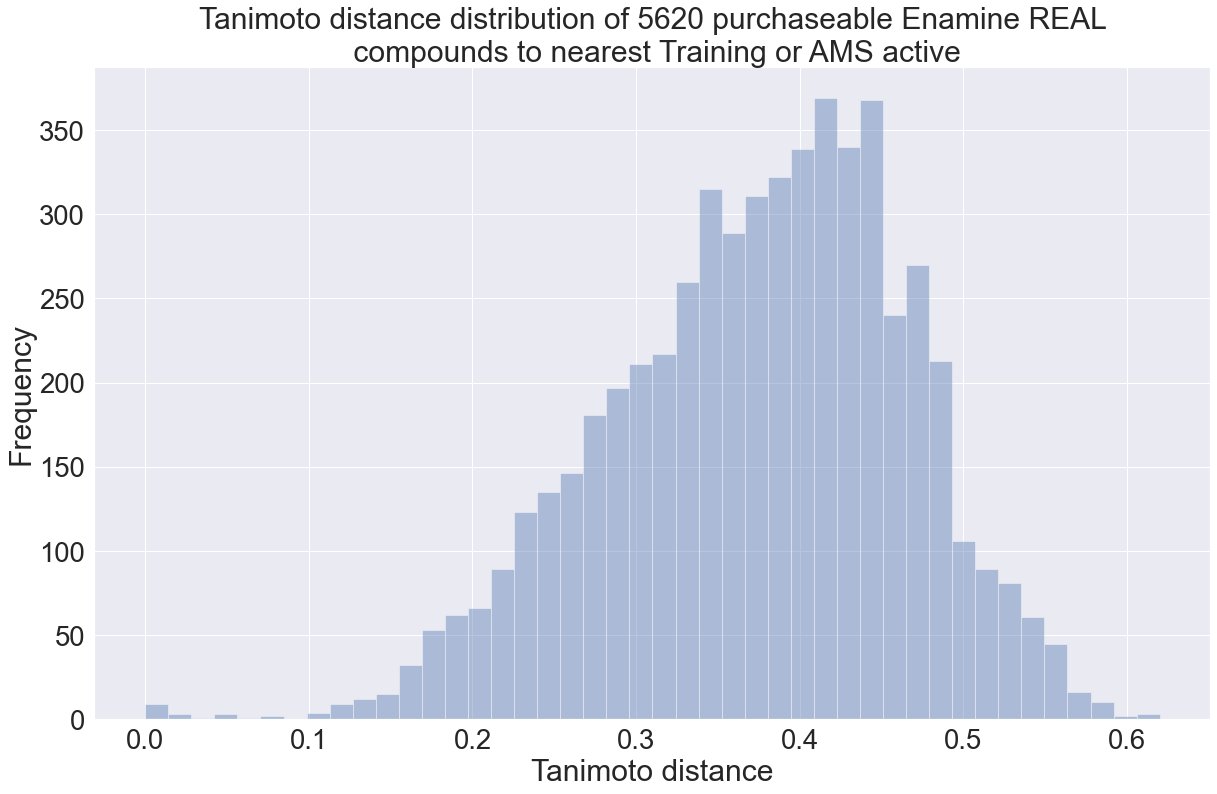

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=2.5);figsize=(20, 12)

tan_dist = top_real_clustering[['Closest Train Active TanDist', 'Closest AMS Active TanDist']].min(axis=1).values
bin_range= [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65] #np.linspace(0.35, 0.65, 10)
plt.figure(figsize=figsize)

sns.distplot(tan_dist, norm_hist=False, kde=False)  
plt.title('Tanimoto distance distribution of 5620 purchaseable Enamine REAL\n compounds to nearest Training or AMS active')
plt.xlabel('Tanimoto distance'); plt.ylabel('Frequency');
plt.show()

In [6]:
top_real_clustering.to_csv('../datasets/real_5629.csv.gz', index=False)